<a href="https://colab.research.google.com/github/kangnurrohman/belajar-recurrent-neural-network/blob/main/materi/Part%202%20-%20RNN%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl luwiji

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 4.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import Data

In [6]:
df = pd.read_csv("/content/data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


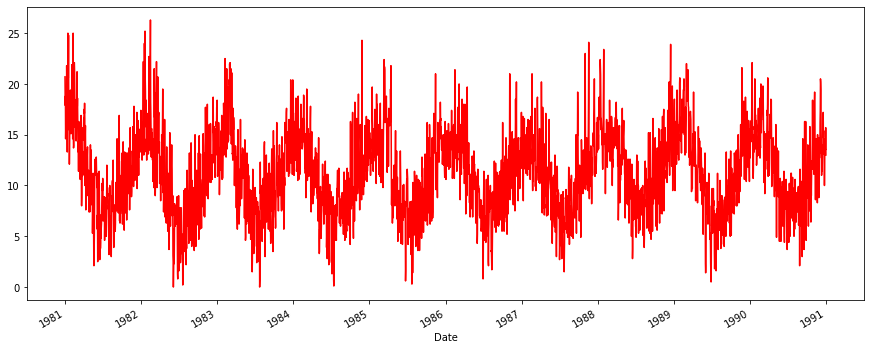

In [7]:
df.Temp.plot(figsize=(15, 6), color='red')

## Dataset Spliting

In [8]:
ts_train, ts_test = train_test_split(df, shuffle=False)
ts_train.shape, ts_test.shape

((2737, 1), (913, 1))

## Dataset & Dataloader

In [9]:
from jcopdl.utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [10]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

(N, S, F): (195, 14, 1)
Note: last 6 data excluded

(N, S, F): (65, 14, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.rnn(x, hidden)
    x = self.fc(x)
    return x, hidden

In [12]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size":64,
    "num_layers": 2,
    "dropout":0
})

## Training Preparation -> MCOC

In [13]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='/content/data/model/rnn')

## Training

In [14]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 3/3 [00:00<00:00, 83.84it/s]



Epoch     1
Train_cost  = 126.2981 | Test_cost  = 105.9732 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.94it/s]



Epoch     2
Train_cost  = 92.5375 | Test_cost  = 80.7612 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.52it/s]



Epoch     3
Train_cost  = 71.9821 | Test_cost  = 65.8725 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 70.44it/s]



Epoch     4
Train_cost  = 59.9259 | Test_cost  = 56.7950 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.18it/s]



Epoch     5
Train_cost  = 52.2034 | Test_cost  = 50.1872 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 74.39it/s]



Epoch     6
Train_cost  = 46.3157 | Test_cost  = 44.7744 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 86.63it/s]



Epoch     7
Train_cost  = 41.4245 | Test_cost  = 40.1661 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 80.76it/s]



Epoch     8
Train_cost  = 37.2594 | Test_cost  = 36.2129 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 70.04it/s]



Epoch     9
Train_cost  = 33.7033 | Test_cost  = 32.8296 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 82.36it/s]



Epoch    10
Train_cost  = 30.6795 | Test_cost  = 29.9481 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.28it/s]



Epoch    11
Train_cost  = 28.1231 | Test_cost  = 27.5075 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 70.37it/s]



Epoch    12
Train_cost  = 25.9757 | Test_cost  = 25.4522 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.50it/s]



Epoch    13
Train_cost  = 24.1835 | Test_cost  = 23.7316 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.91it/s]



Epoch    14
Train_cost  = 22.6981 | Test_cost  = 22.2996 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 69.64it/s]



Epoch    15
Train_cost  = 21.4754 | Test_cost  = 21.1148 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 72.65it/s]



Epoch    16
Train_cost  = 20.4759 | Test_cost  = 20.1400 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 80.15it/s]



Epoch    17
Train_cost  = 19.6644 | Test_cost  = 19.3424 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 80.09it/s]



Epoch    18
Train_cost  = 19.0099 | Test_cost  = 18.6929 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.58it/s]



Epoch    19
Train_cost  = 18.4854 | Test_cost  = 18.1665 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.77it/s]



Epoch    20
Train_cost  = 18.0674 | Test_cost  = 17.7415 | 


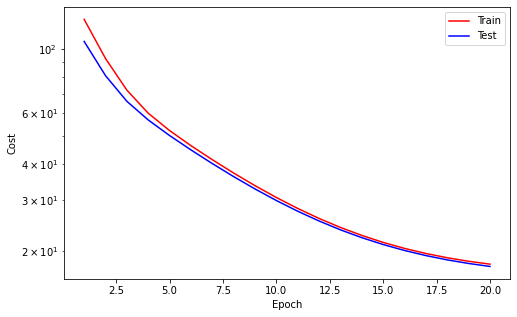

Test: 100%|██████████| 3/3 [00:00<00:00, 60.55it/s]



Epoch    21
Train_cost  = 17.7362 | Test_cost  = 17.3994 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.29it/s]



Epoch    22
Train_cost  = 17.4749 | Test_cost  = 17.1248 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 66.71it/s]



Epoch    23
Train_cost  = 17.2696 | Test_cost  = 16.9047 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.85it/s]



Epoch    24
Train_cost  = 17.1086 | Test_cost  = 16.7284 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.02it/s]



Epoch    25
Train_cost  = 16.9825 | Test_cost  = 16.5872 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.79it/s]



Epoch    26
Train_cost  = 16.8838 | Test_cost  = 16.4739 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.96it/s]



Epoch    27
Train_cost  = 16.8062 | Test_cost  = 16.3827 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 72.00it/s]



Epoch    28
Train_cost  = 16.7450 | Test_cost  = 16.3090 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.31it/s]



Epoch    29
Train_cost  = 16.6962 | Test_cost  = 16.2491 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 72.26it/s]



Epoch    30
Train_cost  = 16.6568 | Test_cost  = 16.1998 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 79.62it/s]



Epoch    31
Train_cost  = 16.6242 | Test_cost  = 16.1587 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.46it/s]



Epoch    32
Train_cost  = 16.5962 | Test_cost  = 16.1235 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 70.09it/s]



Epoch    33
Train_cost  = 16.5710 | Test_cost  = 16.0922 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 72.34it/s]



Epoch    34
Train_cost  = 16.5464 | Test_cost  = 16.0626 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.96it/s]



Epoch    35
Train_cost  = 16.5198 | Test_cost  = 16.0316 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 71.36it/s]



Epoch    36
Train_cost  = 16.4863 | Test_cost  = 15.9923 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.15it/s]



Epoch    37
Train_cost  = 16.4307 | Test_cost  = 15.9190 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.41it/s]



Epoch    38
Train_cost  = 16.2873 | Test_cost  = 15.6983 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.15it/s]



Epoch    39
Train_cost  = 15.8980 | Test_cost  = 15.4242 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.55it/s]



Epoch    40
Train_cost  = 15.1849 | Test_cost  = 14.3924 | 


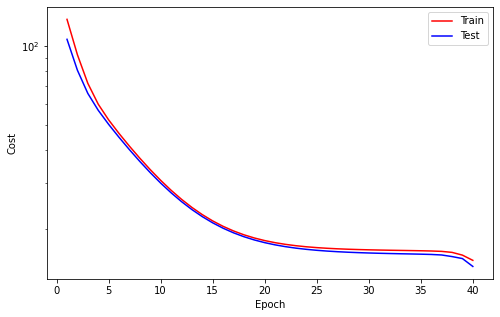

Test: 100%|██████████| 3/3 [00:00<00:00, 40.82it/s]



Epoch    41
Train_cost  = 14.1960 | Test_cost  = 13.8147 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.80it/s]



Epoch    42
Train_cost  = 13.6029 | Test_cost  = 13.1660 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.69it/s]



Epoch    43
Train_cost  = 12.9197 | Test_cost  = 12.5423 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.11it/s]



Epoch    44
Train_cost  = 12.2596 | Test_cost  = 11.9780 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.22it/s]



Epoch    45
Train_cost  = 11.7529 | Test_cost  = 11.5148 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.23it/s]



Epoch    46
Train_cost  = 11.3018 | Test_cost  = 11.0929 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.43it/s]



Epoch    47
Train_cost  = 10.8823 | Test_cost  = 10.6967 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.43it/s]



Epoch    48
Train_cost  = 10.5062 | Test_cost  = 10.3257 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.77it/s]



Epoch    49
Train_cost  = 10.1534 | Test_cost  = 9.9795 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.17it/s]



Epoch    50
Train_cost  = 9.8342 | Test_cost  = 9.6674 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.18it/s]



Epoch    51
Train_cost  = 9.5630 | Test_cost  = 9.3939 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.19it/s]



Epoch    52
Train_cost  = 9.3334 | Test_cost  = 9.1547 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.67it/s]



Epoch    53
Train_cost  = 9.1306 | Test_cost  = 8.9438 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 23.03it/s]



Epoch    54
Train_cost  = 8.9464 | Test_cost  = 8.7602 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.62it/s]



Epoch    55
Train_cost  = 8.7825 | Test_cost  = 8.5958 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.36it/s]



Epoch    56
Train_cost  = 8.6402 | Test_cost  = 8.4449 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.05it/s]



Epoch    57
Train_cost  = 8.5109 | Test_cost  = 8.3066 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.90it/s]



Epoch    58
Train_cost  = 8.3868 | Test_cost  = 8.1788 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.74it/s]



Epoch    59
Train_cost  = 8.2670 | Test_cost  = 8.0606 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.05it/s]



Epoch    60
Train_cost  = 8.1561 | Test_cost  = 7.9493 | 


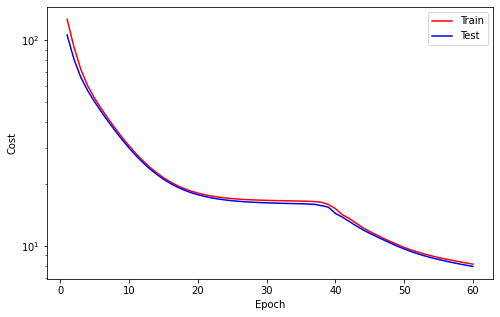

Test: 100%|██████████| 3/3 [00:00<00:00, 28.65it/s]



Epoch    61
Train_cost  = 8.0549 | Test_cost  = 7.8443 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.46it/s]



Epoch    62
Train_cost  = 7.9591 | Test_cost  = 7.7457 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.79it/s]



Epoch    63
Train_cost  = 7.8667 | Test_cost  = 7.6543 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.99it/s]



Epoch    64
Train_cost  = 7.7798 | Test_cost  = 7.5699 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.66it/s]



Epoch    65
Train_cost  = 7.6999 | Test_cost  = 7.4916 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.45it/s]



Epoch    66
Train_cost  = 7.6263 | Test_cost  = 7.4188 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.58it/s]



Epoch    67
Train_cost  = 7.5575 | Test_cost  = 7.3515 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.65it/s]



Epoch    68
Train_cost  = 7.4933 | Test_cost  = 7.2891 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.44it/s]



Epoch    69
Train_cost  = 7.4337 | Test_cost  = 7.2307 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.79it/s]



Epoch    70
Train_cost  = 7.3783 | Test_cost  = 7.1758 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.62it/s]



Epoch    71
Train_cost  = 7.3266 | Test_cost  = 7.1238 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.64it/s]



Epoch    72
Train_cost  = 7.2778 | Test_cost  = 7.0746 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.77it/s]



Epoch    73
Train_cost  = 7.2317 | Test_cost  = 7.0281 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.54it/s]



Epoch    74
Train_cost  = 7.1882 | Test_cost  = 6.9840 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.83it/s]



Epoch    75
Train_cost  = 7.1473 | Test_cost  = 6.9423 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.41it/s]



Epoch    76
Train_cost  = 7.1086 | Test_cost  = 6.9027 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.51it/s]



Epoch    77
Train_cost  = 7.0719 | Test_cost  = 6.8653 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.40it/s]



Epoch    78
Train_cost  = 7.0372 | Test_cost  = 6.8297 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.37it/s]



Epoch    79
Train_cost  = 7.0043 | Test_cost  = 6.7960 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.97it/s]



Epoch    80
Train_cost  = 6.9731 | Test_cost  = 6.7639 | 


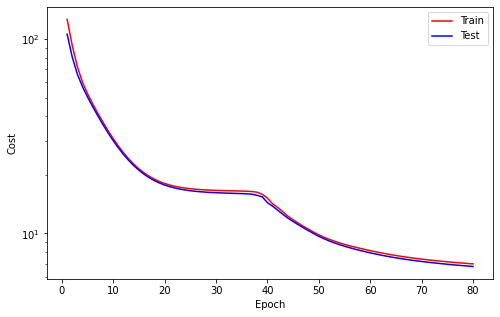

Test: 100%|██████████| 3/3 [00:00<00:00, 40.54it/s]



Epoch    81
Train_cost  = 6.9435 | Test_cost  = 6.7332 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 18.81it/s]



Epoch    82
Train_cost  = 6.9153 | Test_cost  = 6.7040 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 23.04it/s]



Epoch    83
Train_cost  = 6.8885 | Test_cost  = 6.6761 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.67it/s]



Epoch    84
Train_cost  = 6.8630 | Test_cost  = 6.6494 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.22it/s]



Epoch    85
Train_cost  = 6.8387 | Test_cost  = 6.6238 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.64it/s]



Epoch    86
Train_cost  = 6.8154 | Test_cost  = 6.5992 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 18.65it/s]



Epoch    87
Train_cost  = 6.7932 | Test_cost  = 6.5756 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.22it/s]



Epoch    88
Train_cost  = 6.7720 | Test_cost  = 6.5529 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.67it/s]



Epoch    89
Train_cost  = 6.7517 | Test_cost  = 6.5310 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.20it/s]



Epoch    90
Train_cost  = 6.7322 | Test_cost  = 6.5099 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.35it/s]



Epoch    91
Train_cost  = 6.7135 | Test_cost  = 6.4896 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.25it/s]



Epoch    92
Train_cost  = 6.6956 | Test_cost  = 6.4699 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 71.07it/s]



Epoch    93
Train_cost  = 6.6783 | Test_cost  = 6.4509 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.80it/s]



Epoch    94
Train_cost  = 6.6617 | Test_cost  = 6.4325 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.61it/s]



Epoch    95
Train_cost  = 6.6457 | Test_cost  = 6.4147 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.52it/s]



Epoch    96
Train_cost  = 6.6303 | Test_cost  = 6.3975 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 71.44it/s]



Epoch    97
Train_cost  = 6.6155 | Test_cost  = 6.3808 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.50it/s]



Epoch    98
Train_cost  = 6.6011 | Test_cost  = 6.3645 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.89it/s]



Epoch    99
Train_cost  = 6.5872 | Test_cost  = 6.3488 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.68it/s]



Epoch   100
Train_cost  = 6.5738 | Test_cost  = 6.3335 | 


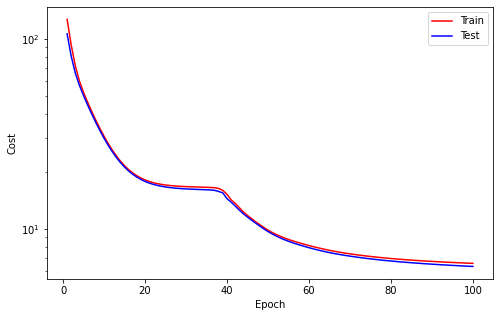

Test: 100%|██████████| 3/3 [00:00<00:00, 63.72it/s]



Epoch   101
Train_cost  = 6.5608 | Test_cost  = 6.3186 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.50it/s]



Epoch   102
Train_cost  = 6.5482 | Test_cost  = 6.3042 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.89it/s]



Epoch   103
Train_cost  = 6.5360 | Test_cost  = 6.2901 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.54it/s]



Epoch   104
Train_cost  = 6.5241 | Test_cost  = 6.2764 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.09it/s]



Epoch   105
Train_cost  = 6.5126 | Test_cost  = 6.2630 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.96it/s]



Epoch   106
Train_cost  = 6.5014 | Test_cost  = 6.2500 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.75it/s]



Epoch   107
Train_cost  = 6.4905 | Test_cost  = 6.2373 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.21it/s]



Epoch   108
Train_cost  = 6.4799 | Test_cost  = 6.2250 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.84it/s]



Epoch   109
Train_cost  = 6.4695 | Test_cost  = 6.2129 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.62it/s]



Epoch   110
Train_cost  = 6.4594 | Test_cost  = 6.2011 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.87it/s]



Epoch   111
Train_cost  = 6.4495 | Test_cost  = 6.1896 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.54it/s]



Epoch   112
Train_cost  = 6.4399 | Test_cost  = 6.1784 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.67it/s]



Epoch   113
Train_cost  = 6.4305 | Test_cost  = 6.1674 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.94it/s]



Epoch   114
Train_cost  = 6.4213 | Test_cost  = 6.1566 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.96it/s]



Epoch   115
Train_cost  = 6.4123 | Test_cost  = 6.1461 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.82it/s]



Epoch   116
Train_cost  = 6.4035 | Test_cost  = 6.1358 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.81it/s]



Epoch   117
Train_cost  = 6.3949 | Test_cost  = 6.1258 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.04it/s]



Epoch   118
Train_cost  = 6.3865 | Test_cost  = 6.1159 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.56it/s]



Epoch   119
Train_cost  = 6.3782 | Test_cost  = 6.1063 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 69.52it/s]



Epoch   120
Train_cost  = 6.3701 | Test_cost  = 6.0969 | 


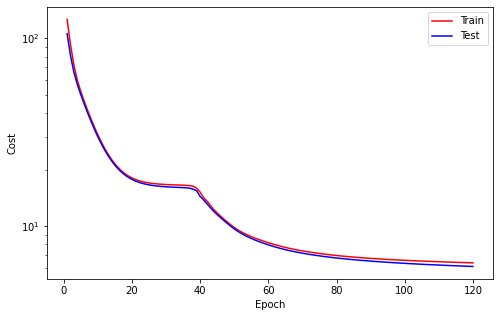

Test: 100%|██████████| 3/3 [00:00<00:00, 60.76it/s]



Epoch   121
Train_cost  = 6.3622 | Test_cost  = 6.0876 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 69.94it/s]



Epoch   122
Train_cost  = 6.3544 | Test_cost  = 6.0786 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.35it/s]



Epoch   123
Train_cost  = 6.3467 | Test_cost  = 6.0697 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 76.00it/s]



Epoch   124
Train_cost  = 6.3392 | Test_cost  = 6.0611 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 76.87it/s]



Epoch   125
Train_cost  = 6.3319 | Test_cost  = 6.0526 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.79it/s]



Epoch   126
Train_cost  = 6.3247 | Test_cost  = 6.0442 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 74.05it/s]



Epoch   127
Train_cost  = 6.3176 | Test_cost  = 6.0361 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.51it/s]



Epoch   128
Train_cost  = 6.3107 | Test_cost  = 6.0280 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.48it/s]



Epoch   129
Train_cost  = 6.3039 | Test_cost  = 6.0202 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.12it/s]



Epoch   130
Train_cost  = 6.2972 | Test_cost  = 6.0125 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.12it/s]



Epoch   131
Train_cost  = 6.2906 | Test_cost  = 6.0049 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 74.22it/s]



Epoch   132
Train_cost  = 6.2842 | Test_cost  = 5.9975 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.41it/s]



Epoch   133
Train_cost  = 6.2779 | Test_cost  = 5.9903 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 75.29it/s]



Epoch   134
Train_cost  = 6.2717 | Test_cost  = 5.9831 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.37it/s]



Epoch   135
Train_cost  = 6.2655 | Test_cost  = 5.9761 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.07it/s]



Epoch   136
Train_cost  = 6.2596 | Test_cost  = 5.9692 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.24it/s]



Epoch   137
Train_cost  = 6.2537 | Test_cost  = 5.9624 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.27it/s]



Epoch   138
Train_cost  = 6.2479 | Test_cost  = 5.9558 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.32it/s]



Epoch   139
Train_cost  = 6.2422 | Test_cost  = 5.9492 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.28it/s]



Epoch   140
Train_cost  = 6.2366 | Test_cost  = 5.9428 | 


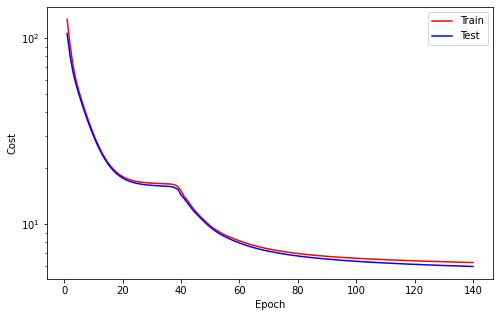

Test: 100%|██████████| 3/3 [00:00<00:00, 44.41it/s]



Epoch   141
Train_cost  = 6.2311 | Test_cost  = 5.9365 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.60it/s]



Epoch   142
Train_cost  = 6.2256 | Test_cost  = 5.9303 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.26it/s]



Epoch   143
Train_cost  = 6.2203 | Test_cost  = 5.9242 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.09it/s]



Epoch   144
Train_cost  = 6.2150 | Test_cost  = 5.9182 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.07it/s]



Epoch   145
Train_cost  = 6.2099 | Test_cost  = 5.9123 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.96it/s]



Epoch   146
Train_cost  = 6.2048 | Test_cost  = 5.9065 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.99it/s]



Epoch   147
Train_cost  = 6.1997 | Test_cost  = 5.9008 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.05it/s]



Epoch   148
Train_cost  = 6.1948 | Test_cost  = 5.8952 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.73it/s]



Epoch   149
Train_cost  = 6.1899 | Test_cost  = 5.8897 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.67it/s]



Epoch   150
Train_cost  = 6.1851 | Test_cost  = 5.8842 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.64it/s]



Epoch   151
Train_cost  = 6.1804 | Test_cost  = 5.8789 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 72.06it/s]



Epoch   152
Train_cost  = 6.1757 | Test_cost  = 5.8736 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.33it/s]



Epoch   153
Train_cost  = 6.1710 | Test_cost  = 5.8685 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.93it/s]



Epoch   154
Train_cost  = 6.1665 | Test_cost  = 5.8634 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.43it/s]



Epoch   155
Train_cost  = 6.1620 | Test_cost  = 5.8584 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 73.24it/s]



Epoch   156
Train_cost  = 6.1575 | Test_cost  = 5.8535 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 68.16it/s]



Epoch   157
Train_cost  = 6.1531 | Test_cost  = 5.8487 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.27it/s]



Epoch   158
Train_cost  = 6.1488 | Test_cost  = 5.8439 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.42it/s]



Epoch   159
Train_cost  = 6.1445 | Test_cost  = 5.8392 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.05it/s]



Epoch   160
Train_cost  = 6.1402 | Test_cost  = 5.8346 | 


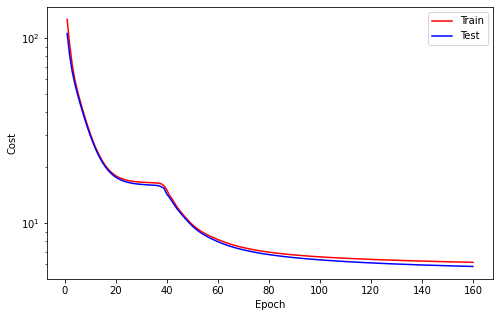

Test: 100%|██████████| 3/3 [00:00<00:00, 48.92it/s]



Epoch   161
Train_cost  = 6.1360 | Test_cost  = 5.8301 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.37it/s]



Epoch   162
Train_cost  = 6.1318 | Test_cost  = 5.8257 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.18it/s]



Epoch   163
Train_cost  = 6.1277 | Test_cost  = 5.8213 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.80it/s]



Epoch   164
Train_cost  = 6.1236 | Test_cost  = 5.8170 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.17it/s]



Epoch   165
Train_cost  = 6.1196 | Test_cost  = 5.8128 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.91it/s]



Epoch   166
Train_cost  = 6.1155 | Test_cost  = 5.8086 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.86it/s]



Epoch   167
Train_cost  = 6.1116 | Test_cost  = 5.8045 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.77it/s]



Epoch   168
Train_cost  = 6.1076 | Test_cost  = 5.8005 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.84it/s]



Epoch   169
Train_cost  = 6.1037 | Test_cost  = 5.7966 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.87it/s]



Epoch   170
Train_cost  = 6.0998 | Test_cost  = 5.7927 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.04it/s]



Epoch   171
Train_cost  = 6.0960 | Test_cost  = 5.7889 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 70.21it/s]



Epoch   172
Train_cost  = 6.0921 | Test_cost  = 5.7852 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.59it/s]



Epoch   173
Train_cost  = 6.0883 | Test_cost  = 5.7815 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.49it/s]



Epoch   174
Train_cost  = 6.0845 | Test_cost  = 5.7779 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.75it/s]



Epoch   175
Train_cost  = 6.0808 | Test_cost  = 5.7744 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.07it/s]



Epoch   176
Train_cost  = 6.0770 | Test_cost  = 5.7710 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.59it/s]



Epoch   177
Train_cost  = 6.0733 | Test_cost  = 5.7676 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.17it/s]



Epoch   178
Train_cost  = 6.0696 | Test_cost  = 5.7643 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.74it/s]



Epoch   179
Train_cost  = 6.0659 | Test_cost  = 5.7610 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.73it/s]



Epoch   180
Train_cost  = 6.0623 | Test_cost  = 5.7578 | 


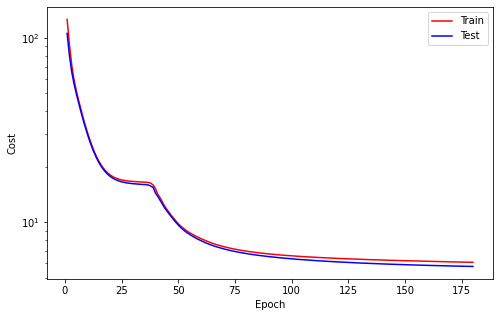

Test: 100%|██████████| 3/3 [00:00<00:00, 46.72it/s]



Epoch   181
Train_cost  = 6.0586 | Test_cost  = 5.7547 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.26it/s]



Epoch   182
Train_cost  = 6.0550 | Test_cost  = 5.7516 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.85it/s]



Epoch   183
Train_cost  = 6.0514 | Test_cost  = 5.7486 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.63it/s]



Epoch   184
Train_cost  = 6.0478 | Test_cost  = 5.7456 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.75it/s]



Epoch   185
Train_cost  = 6.0442 | Test_cost  = 5.7427 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.20it/s]



Epoch   186
Train_cost  = 6.0406 | Test_cost  = 5.7399 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.78it/s]



Epoch   187
Train_cost  = 6.0370 | Test_cost  = 5.7371 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.49it/s]



Epoch   188
Train_cost  = 6.0334 | Test_cost  = 5.7344 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.70it/s]



Epoch   189
Train_cost  = 6.0299 | Test_cost  = 5.7317 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.02it/s]



Epoch   190
Train_cost  = 6.0263 | Test_cost  = 5.7291 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.97it/s]



Epoch   191
Train_cost  = 6.0227 | Test_cost  = 5.7265 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.64it/s]



Epoch   192
Train_cost  = 6.0192 | Test_cost  = 5.7239 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.57it/s]



Epoch   193
Train_cost  = 6.0156 | Test_cost  = 5.7214 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.69it/s]



Epoch   194
Train_cost  = 6.0121 | Test_cost  = 5.7189 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.29it/s]



Epoch   195
Train_cost  = 6.0086 | Test_cost  = 5.7165 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.11it/s]



Epoch   196
Train_cost  = 6.0050 | Test_cost  = 5.7141 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.14it/s]



Epoch   197
Train_cost  = 6.0015 | Test_cost  = 5.7117 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.46it/s]



Epoch   198
Train_cost  = 5.9980 | Test_cost  = 5.7094 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.09it/s]



Epoch   199
Train_cost  = 5.9944 | Test_cost  = 5.7070 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.77it/s]



Epoch   200
Train_cost  = 5.9909 | Test_cost  = 5.7047 | 


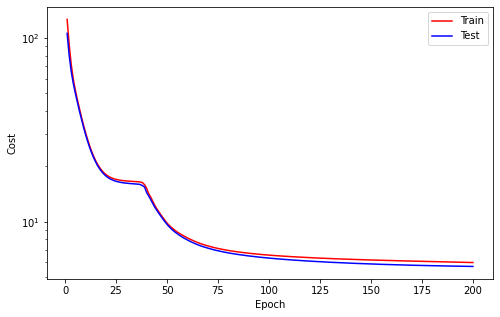

Test: 100%|██████████| 3/3 [00:00<00:00, 59.61it/s]



Epoch   201
Train_cost  = 5.9874 | Test_cost  = 5.7025 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.04it/s]



Epoch   202
Train_cost  = 5.9838 | Test_cost  = 5.7002 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.33it/s]



Epoch   203
Train_cost  = 5.9803 | Test_cost  = 5.6979 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.64it/s]



Epoch   204
Train_cost  = 5.9768 | Test_cost  = 5.6957 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.72it/s]



Epoch   205
Train_cost  = 5.9733 | Test_cost  = 5.6935 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.17it/s]



Epoch   206
Train_cost  = 5.9697 | Test_cost  = 5.6913 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.27it/s]



Epoch   207
Train_cost  = 5.9662 | Test_cost  = 5.6891 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.21it/s]



Epoch   208
Train_cost  = 5.9627 | Test_cost  = 5.6869 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.21it/s]



Epoch   209
Train_cost  = 5.9591 | Test_cost  = 5.6846 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.51it/s]



Epoch   210
Train_cost  = 5.9556 | Test_cost  = 5.6824 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.34it/s]



Epoch   211
Train_cost  = 5.9520 | Test_cost  = 5.6802 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.69it/s]



Epoch   212
Train_cost  = 5.9485 | Test_cost  = 5.6780 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.40it/s]



Epoch   213
Train_cost  = 5.9449 | Test_cost  = 5.6758 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.15it/s]



Epoch   214
Train_cost  = 5.9414 | Test_cost  = 5.6736 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.47it/s]



Epoch   215
Train_cost  = 5.9378 | Test_cost  = 5.6714 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.39it/s]



Epoch   216
Train_cost  = 5.9342 | Test_cost  = 5.6691 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.44it/s]



Epoch   217
Train_cost  = 5.9306 | Test_cost  = 5.6669 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.17it/s]



Epoch   218
Train_cost  = 5.9270 | Test_cost  = 5.6646 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.24it/s]



Epoch   219
Train_cost  = 5.9233 | Test_cost  = 5.6624 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.24it/s]



Epoch   220
Train_cost  = 5.9197 | Test_cost  = 5.6601 | 


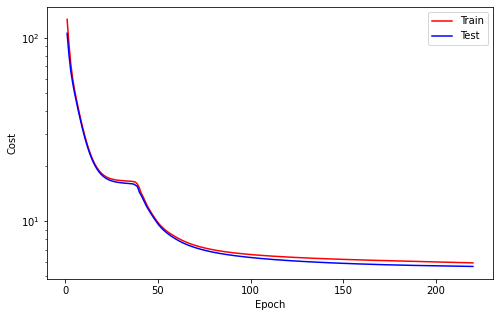

Test: 100%|██████████| 3/3 [00:00<00:00, 56.88it/s]



Epoch   221
Train_cost  = 5.9160 | Test_cost  = 5.6579 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.37it/s]



Epoch   222
Train_cost  = 5.9122 | Test_cost  = 5.6556 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.10it/s]



Epoch   223
Train_cost  = 5.9085 | Test_cost  = 5.6534 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.62it/s]



Epoch   224
Train_cost  = 5.9046 | Test_cost  = 5.6511 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.33it/s]



Epoch   225
Train_cost  = 5.9008 | Test_cost  = 5.6489 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.83it/s]



Epoch   226
Train_cost  = 5.8968 | Test_cost  = 5.6467 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.83it/s]



Epoch   227
Train_cost  = 5.8928 | Test_cost  = 5.6446 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.42it/s]



Epoch   228
Train_cost  = 5.8887 | Test_cost  = 5.6425 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.58it/s]



Epoch   229
Train_cost  = 5.8846 | Test_cost  = 5.6404 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.08it/s]



Epoch   230
Train_cost  = 5.8804 | Test_cost  = 5.6384 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.80it/s]



Epoch   231
Train_cost  = 5.8762 | Test_cost  = 5.6365 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.77it/s]



Epoch   232
Train_cost  = 5.8720 | Test_cost  = 5.6345 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.34it/s]



Epoch   233
Train_cost  = 5.8677 | Test_cost  = 5.6326 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.10it/s]



Epoch   234
Train_cost  = 5.8634 | Test_cost  = 5.6308 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.20it/s]



Epoch   235
Train_cost  = 5.8591 | Test_cost  = 5.6290 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.85it/s]



Epoch   236
Train_cost  = 5.8548 | Test_cost  = 5.6274 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.65it/s]



Epoch   237
Train_cost  = 5.8504 | Test_cost  = 5.6258 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.85it/s]



Epoch   238
Train_cost  = 5.8460 | Test_cost  = 5.6244 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.33it/s]



Epoch   239
Train_cost  = 5.8415 | Test_cost  = 5.6230 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.68it/s]



Epoch   240
Train_cost  = 5.8369 | Test_cost  = 5.6217 | 


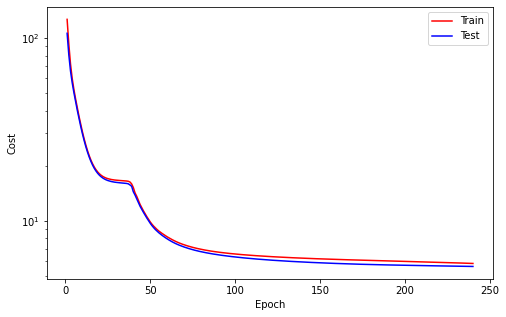

Test: 100%|██████████| 3/3 [00:00<00:00, 54.92it/s]



Epoch   241
Train_cost  = 5.8322 | Test_cost  = 5.6204 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.04it/s]



Epoch   242
Train_cost  = 5.8275 | Test_cost  = 5.6191 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.86it/s]



Epoch   243
Train_cost  = 5.8227 | Test_cost  = 5.6179 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.24it/s]



Epoch   244
Train_cost  = 5.8178 | Test_cost  = 5.6168 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.13it/s]



Epoch   245
Train_cost  = 5.8129 | Test_cost  = 5.6158 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.63it/s]



Epoch   246
Train_cost  = 5.8079 | Test_cost  = 5.6148 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.31it/s]



Epoch   247
Train_cost  = 5.8028 | Test_cost  = 5.6138 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.32it/s]



Epoch   248
Train_cost  = 5.7977 | Test_cost  = 5.6130 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.23it/s]



Epoch   249
Train_cost  = 5.7924 | Test_cost  = 5.6122 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.58it/s]



Epoch   250
Train_cost  = 5.7871 | Test_cost  = 5.6114 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.51it/s]



Epoch   251
Train_cost  = 5.7817 | Test_cost  = 5.6108 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.00it/s]



Epoch   252
Train_cost  = 5.7762 | Test_cost  = 5.6102 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.85it/s]



Epoch   253
Train_cost  = 5.7707 | Test_cost  = 5.6097 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.78it/s]



Epoch   254
Train_cost  = 5.7650 | Test_cost  = 5.6093 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.58it/s]



Epoch   255
Train_cost  = 5.7592 | Test_cost  = 5.6090 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.92it/s]



Epoch   256
Train_cost  = 5.7534 | Test_cost  = 5.6088 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.41it/s]



Epoch   257
Train_cost  = 5.7474 | Test_cost  = 5.6087 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.29it/s]



Epoch   258
Train_cost  = 5.7414 | Test_cost  = 5.6086 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.71it/s]



Epoch   259
Train_cost  = 5.7352 | Test_cost  = 5.6087 | 
==> EarlyStop patience =  1 | Best test_cost: 5.6086


Test: 100%|██████████| 3/3 [00:00<00:00, 45.85it/s]



Epoch   260
Train_cost  = 5.7290 | Test_cost  = 5.6089 | 


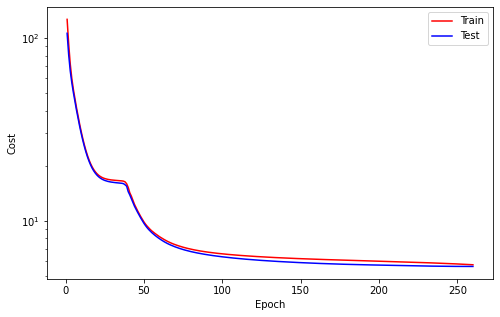

==> EarlyStop patience =  2 | Best test_cost: 5.6086


Test: 100%|██████████| 3/3 [00:00<00:00, 53.65it/s]



Epoch   261
Train_cost  = 5.7226 | Test_cost  = 5.6092 | 
==> EarlyStop patience =  3 | Best test_cost: 5.6086


Test: 100%|██████████| 3/3 [00:00<00:00, 55.33it/s]



Epoch   262
Train_cost  = 5.7161 | Test_cost  = 5.6096 | 
==> EarlyStop patience =  4 | Best test_cost: 5.6086


Test: 100%|██████████| 3/3 [00:00<00:00, 56.37it/s]



Epoch   263
Train_cost  = 5.7096 | Test_cost  = 5.6101 | 
==> EarlyStop patience =  5 | Best test_cost: 5.6086
==> Execute Early Stopping at epoch: 263 | Best test_cost: 5.6086
==> Best model is saved at /content/data/model/rnn


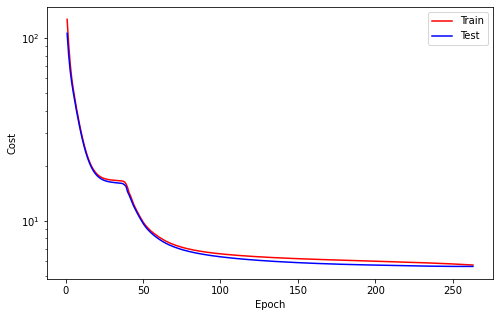

In [15]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [16]:
from luwiji.rnn import illustration

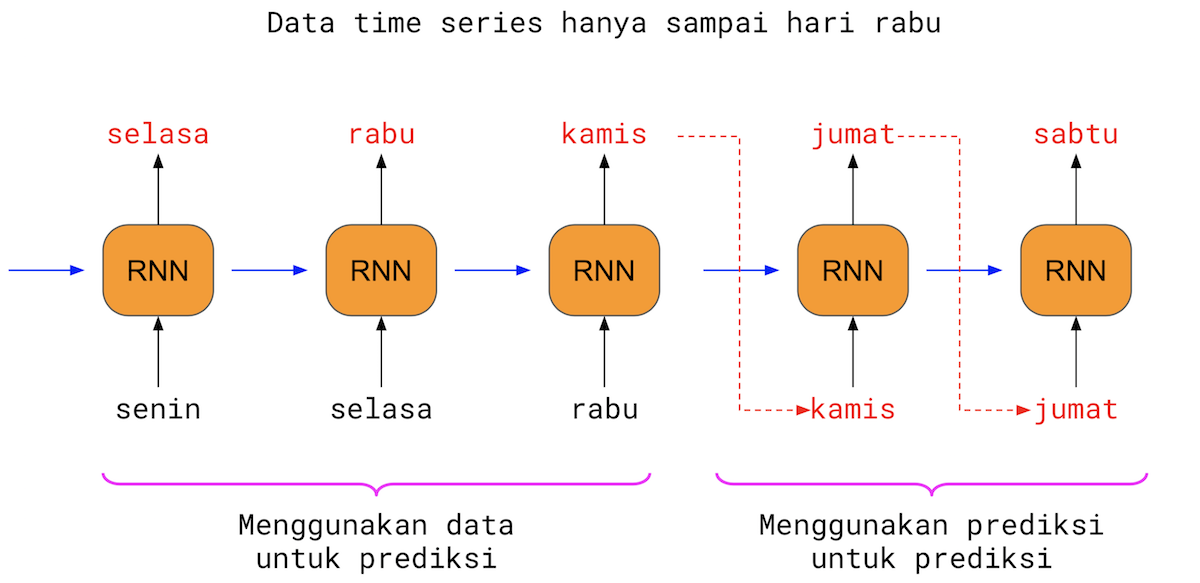

In [17]:
illustration.forecast

In [18]:
# utils
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()   

In [19]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2736, 1, 1)
Note: last 0 data excluded

(N, S, F): (912, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

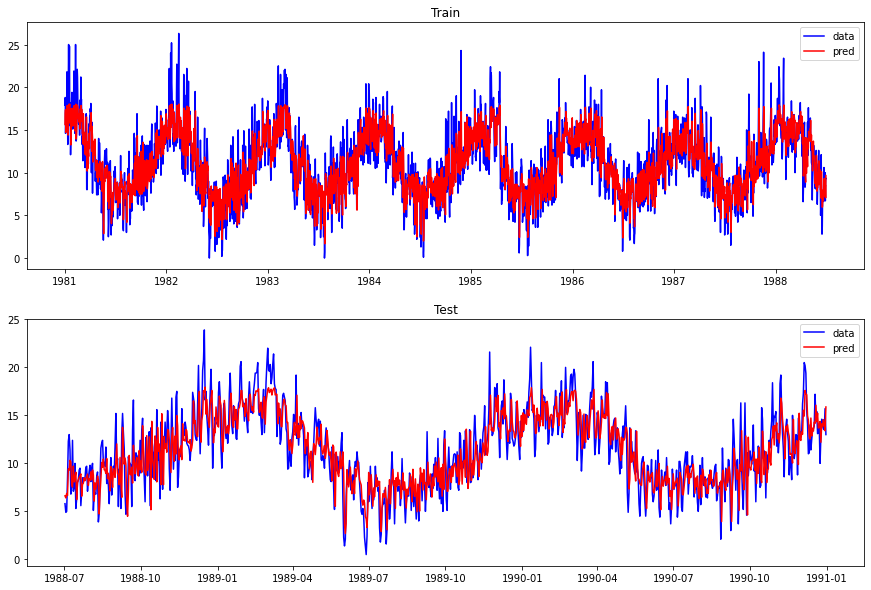

In [20]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

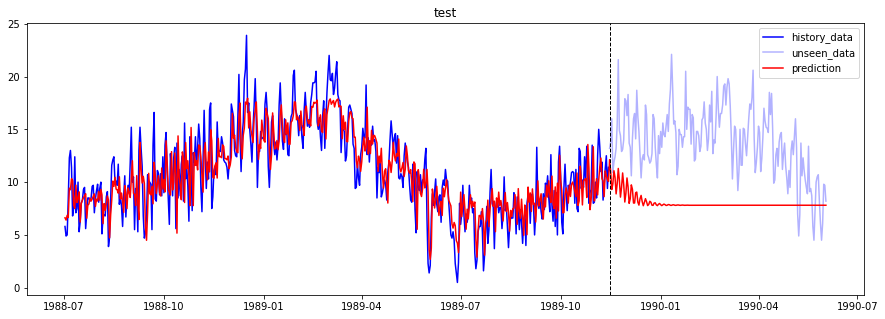

In [21]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")